In [2]:
import numpy as np
import matplotlib.pyplot as plt
import colorednoise as cn

from os import makedirs
from os.path import exists, join
from scipy.signal import welch

from lagged_autocoherence import ar_surr, lagged_hilbert_autocoherence

In [2]:
# Helper functions.

def compute_rms(time_series):
    return np.sqrt(np.mean(np.square(time_series)))

def scale_noise(signal_without_noise, noise, desired_snr_db):
    # Compute power of the original signal
    Ps = compute_rms(signal_without_noise)**2
    
    # Convert desired SNR from dB to linear scale
    snr_linear = 10**(desired_snr_db / 10)
    
    # Calculate the desired noise power based on the desired SNR
    desired_noise_power = Ps / snr_linear
    
    # Compute scaling factor for the noise
    alpha = np.sqrt(desired_noise_power / compute_rms(noise)**2)
    
    return alpha * noise

def gen_signal(T, trials, srate, fs, snr_db):
    time=np.linspace(0,T,T*srate)
    
    w = 2. * np.pi * f
    signal=np.zeros((trials,len(time)))
    for i in range(trials):
        pure_signal = np.sin(w * (time + np.random.randn()))
        noise = cn.powerlaw_psd_gaussian(1, len(time))
        scaled_noise = scale_noise(pure_signal, noise, snr_db)        
        
        signal[i,:]=pure_signal+scaled_noise

    return signal

In [ ]:
# Simulation hyper-parameters.

simulations = "osc"

surr_methods = ["arma", "phase"]

# Signal hyper-params.
T = 5
trials = 100
srate = 1000
snr = -20 # 0

# Frequency resolution.
f_min = 5
f_max = 100
n_freqs = ((f_max - f_min) * 2) + 1
osc_f = np.array([10, 25, 50]) # np.arange(10, 55, 5)

# Surrogate analysis.
lags = np.arange(1, 6.5, 0.5)
n_shuffles = 300

# Directories.
p_dir = "./simulations/oscillations/snr_{}/".format(int(snr))

In [4]:
# Create simulated signals.

# Generate and save signals and PSDs per frequency.
for f_idx, f in enumerate(osc_f):
    
    print('Simulating {} Hz oscillatory signals.'.format(f))

    wdir = join(p_dir, "osc_{}/".format(int(f)))
    if not exists(wdir):
        makedirs(wdir)
    
    signals = gen_signal(T, trials, srate, f, snr)

    freqs, psds = welch(
        signals,
        fs=srate,
        window='hann',
        nperseg=srate,
        noverlap=int(srate / 2),
        nfft=srate * 2,
        detrend='constant',
        return_onesided=True,
        scaling='density',
        axis=-1,
        average='mean'
    )
    
    idx = (freqs >= f_min) & (freqs <= f_max)
    freqs = freqs[idx]
    psds = psds[:,idx]

    np.save(join(wdir, "osc_signals"), signals)
    np.save(join(wdir, "osc_psds"), psds)
    np.save(join(wdir, "osc_freqs"), freqs)

Simulating 10 Hz oscillatory signals.
Simulating 25 Hz oscillatory signals.
Simulating 50 Hz oscillatory signals.


In [4]:
# Generate surrogate data based on simulated signals and compute the corresponding PSDs.

# Generate and autocoherence per frequency.
for f_idx, f in enumerate(osc_f):

    print('Analyzing simulated {} Hz oscillatory signals.'.format(f))

    wdir = join(p_dir, "osc_{}/".format(int(f)))
    
    signals = np.load(join(wdir, "osc_signals.npy"))

    for method in surr_methods:
        surrogate_signals = ar_surr(
            signals,
            n_shuffles=n_shuffles,
            method=method,
            n_jobs=-1,
        )

        np.save(join(wdir, "surr_{}_osc_signals".format("arma" if method == "arma" else "phs")), surrogate_signals)

        freqs, surrogate_psds = welch(
            surrogate_signals,
            fs=srate,
            window='hann',
            nperseg=srate,
            noverlap=int(srate / 2),
            nfft=srate * 2,
            detrend='constant',
            return_onesided=True,
            scaling='density',
            axis=-1,
            average='mean'
        )

        idx = (freqs >= f_min) & (freqs <= f_max)
        freqs = freqs[idx]
        surrogate_psds = surrogate_psds[:,:,idx]

        np.save(join(wdir, "surr_{}_osc_psds".format("arma" if method == "arma" else "phs")), surrogate_psds)

Analyzing simulated 10 Hz oscillatory signals.
Analyzing simulated 25 Hz oscillatory signals.
Analyzing simulated 50 Hz oscillatory signals.


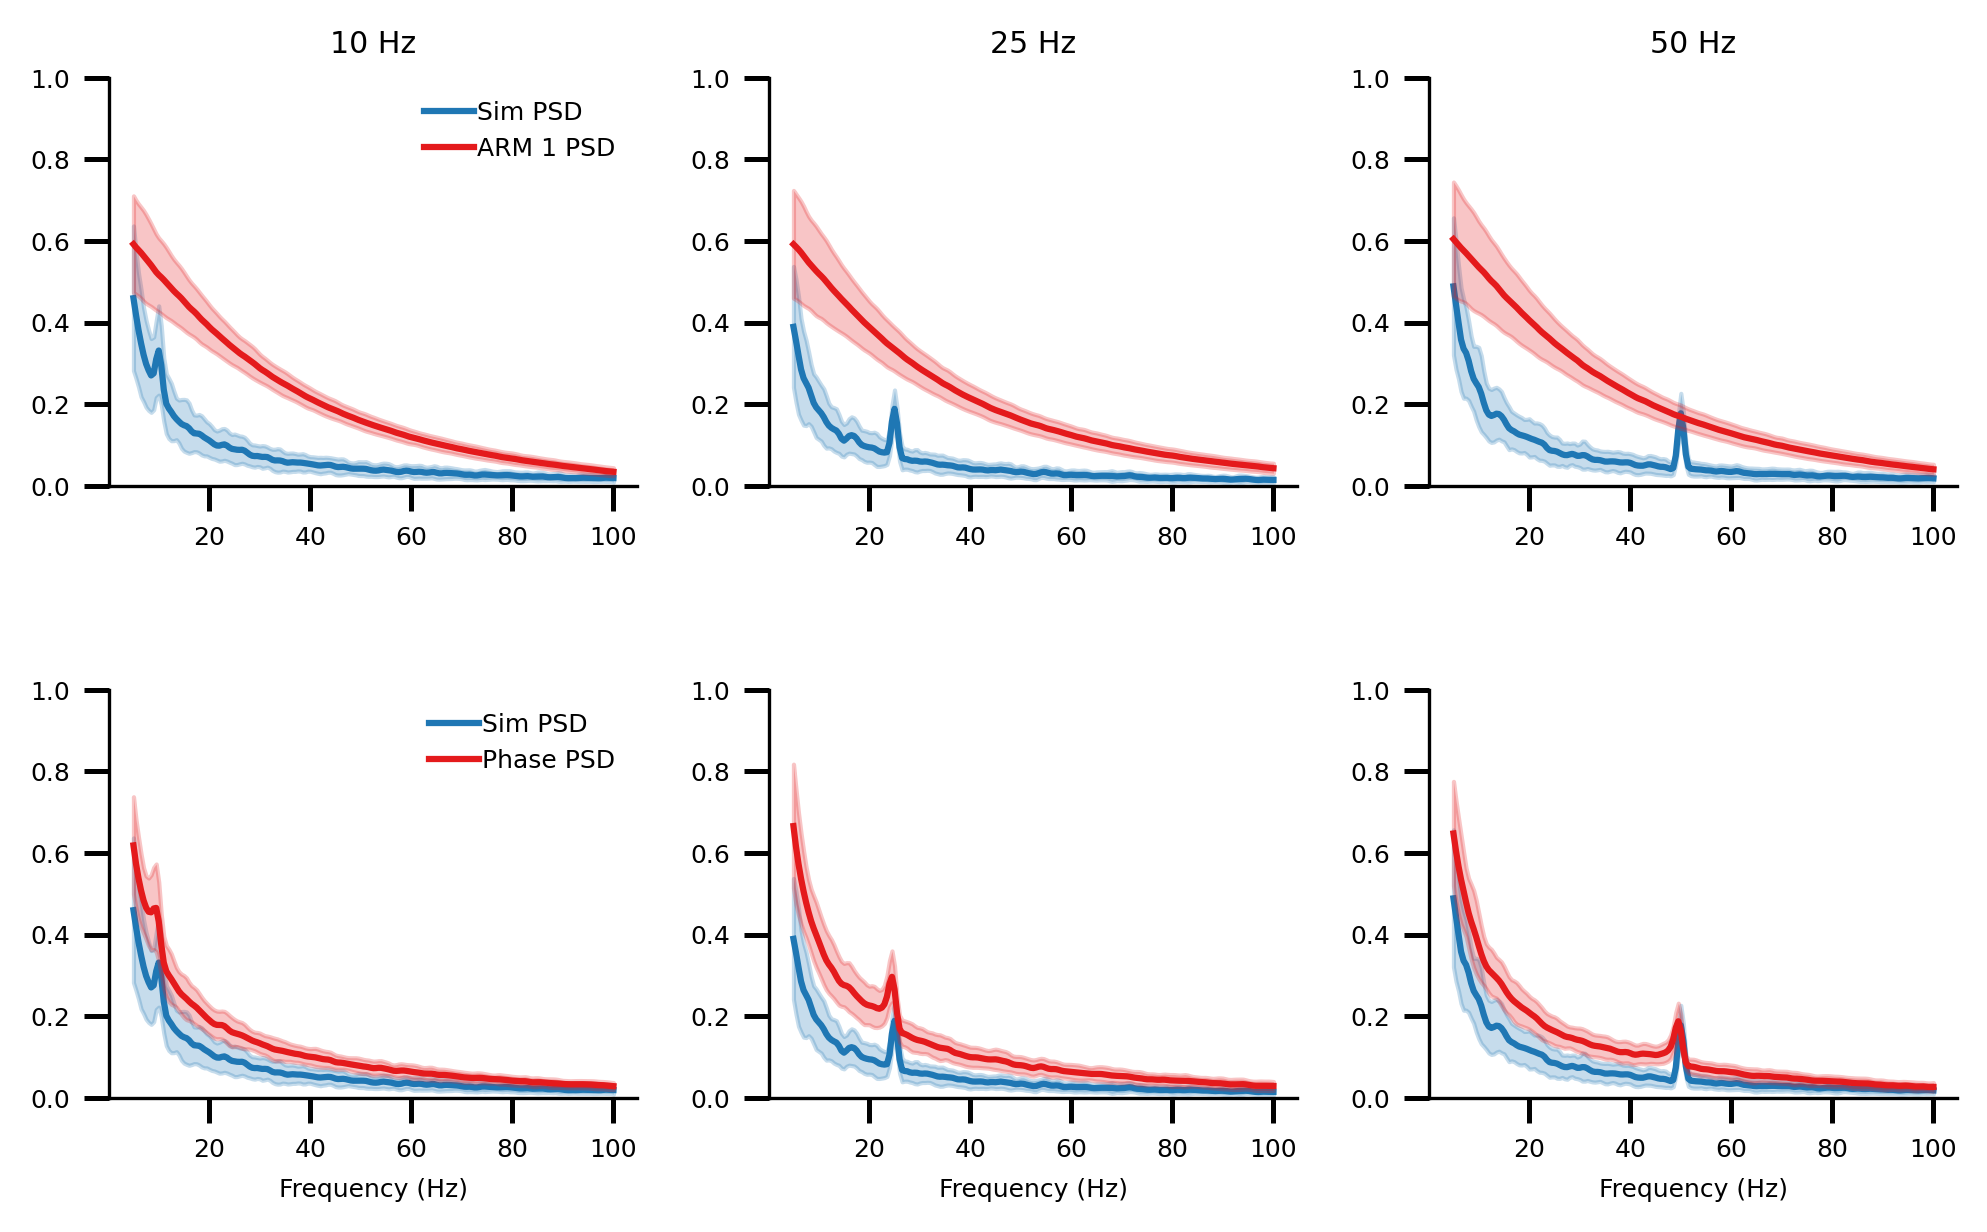

In [ ]:
# Plot PSDs of simulated and surrogate signals.

plt.rcParams.update({
    'font.size': 6,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

psd_color = np.array([228,26,28]) / 255
sim_color = "tab:blue"

fig = plt.figure(
    constrained_layout=False,
    figsize=(7, 4),
    dpi=300,
)
gs = fig.add_gridspec(
    nrows=1,
    ncols=1,
    right=0.95,
    left=0.07,
    top=0.95,
    bottom=0.10,
)
gs0 = gs[0].subgridspec(2, 3, hspace=0.50, wspace=0.25)

for m, method in enumerate(surr_methods):

    for f, fr in enumerate(osc_f):

        # Load data.
        wdir = join(p_dir, "osc_{}/".format(int(fr)))
        
        freqs = np.load(join(wdir, "osc_freqs.npy"))
        psds = np.load(join(wdir, "osc_psds.npy"))
        surrogate_psds = np.load(join(wdir, "surr_{}_osc_psds.npy".format("arma" if method == "arma" else "phs")))

        # Average data across shuffles and apply scaling.
        sap = np.nanmean(surrogate_psds, axis=1)
        sap = ( sap - np.nanmin(sap) ) / ( np.nanmax(sap) - np.nanmin(sap) ) # np.nanmax(sap) #
        sap_m = np.nanmean(sap, axis=0)
        sap_sd = np.nanstd(sap, axis=0)

        psd = ( psds - np.nanmin(psds) ) / ( np.nanmax(psds) - np.nanmin(psds) ) # np.nanmax(psds) #
        psd_m = np.nanmean(psd, axis=0)
        psd_sd = np.nanstd(psd, axis=0)

        # Plot.
        ax0 = fig.add_subplot(gs0[m,f])

        ax0.plot(
            freqs,
            psd_m,
            label='Sim PSD',
            color=sim_color,
            zorder=0,
        )
        ax0.fill_between(
            freqs,
            psd_m - psd_sd,
            psd_m + psd_sd,
            color=sim_color,
            alpha=0.25,
            zorder=0,
        )

        ax0.plot(
            freqs,
            sap_m,
            label='ARM 1 PSD' if method == "arma" else "Phase PSD",
            color=psd_color,
            zorder=1,
        )
        ax0.fill_between(
            freqs,
            sap_m - sap_sd,
            sap_m + sap_sd,
            color=psd_color,
            alpha=0.25,
            zorder=1,
        )

        if m == 0:
            ax0.set_title("{} Hz".format(fr))
        if m == 1:
            ax0.set_xlabel('Frequency (Hz)')
        ax0.set_ylim([0, 1])
        
        if f == 0:
            ax0.legend(loc="upper right")

plt.show()

In [8]:
# Compute lagged Hilbert autocoherence of surrogate data.

# Generate and autocoherence per frequency.
for f_idx, f in enumerate(osc_f):

    print('Analyzing simulated {} Hz oscillatory signals.'.format(f))

    wdir = join(p_dir, "osc_{}/".format(int(f)))
    
    freqs = np.load(join(wdir, "osc_freqs.npy"))

    for method in surr_methods:
        surrogate_signals = np.load(join(wdir, "surr_{}_osc_signals.npy".format("arma" if method == "arma" else "phs")))

        # Random sample of surrogate signals.
        # (the bottleneck is the autocoherence computation, so at least
        # we can minimize the number of repetitions that are needed)
        ids = np.random.randint(low=0, high=surrogate_signals.shape[0], size=int(surrogate_signals.shape[0] / 10))

        lcs_hilbert = []
        for sas in surrogate_signals[ids,:,:]:

            lcs_hilbert.append(
                lagged_hilbert_autocoherence(
                    sas,
                    freqs,
                    lags,
                    srate,
                    thresh_prctile=None,
                    n_jobs=-1,
                )
            )

        lcs_hilbert = np.array(lcs_hilbert)

        np.save(join(wdir, "sur_{}_osc_lcs_hilbert".format("arma" if method == "arma" else "phs")), lcs_hilbert)

Analyzing simulated 10 Hz oscillatory signals.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert autocoherence without surrogate analysis and thresholding.
Conputing lagged Hilbert auto

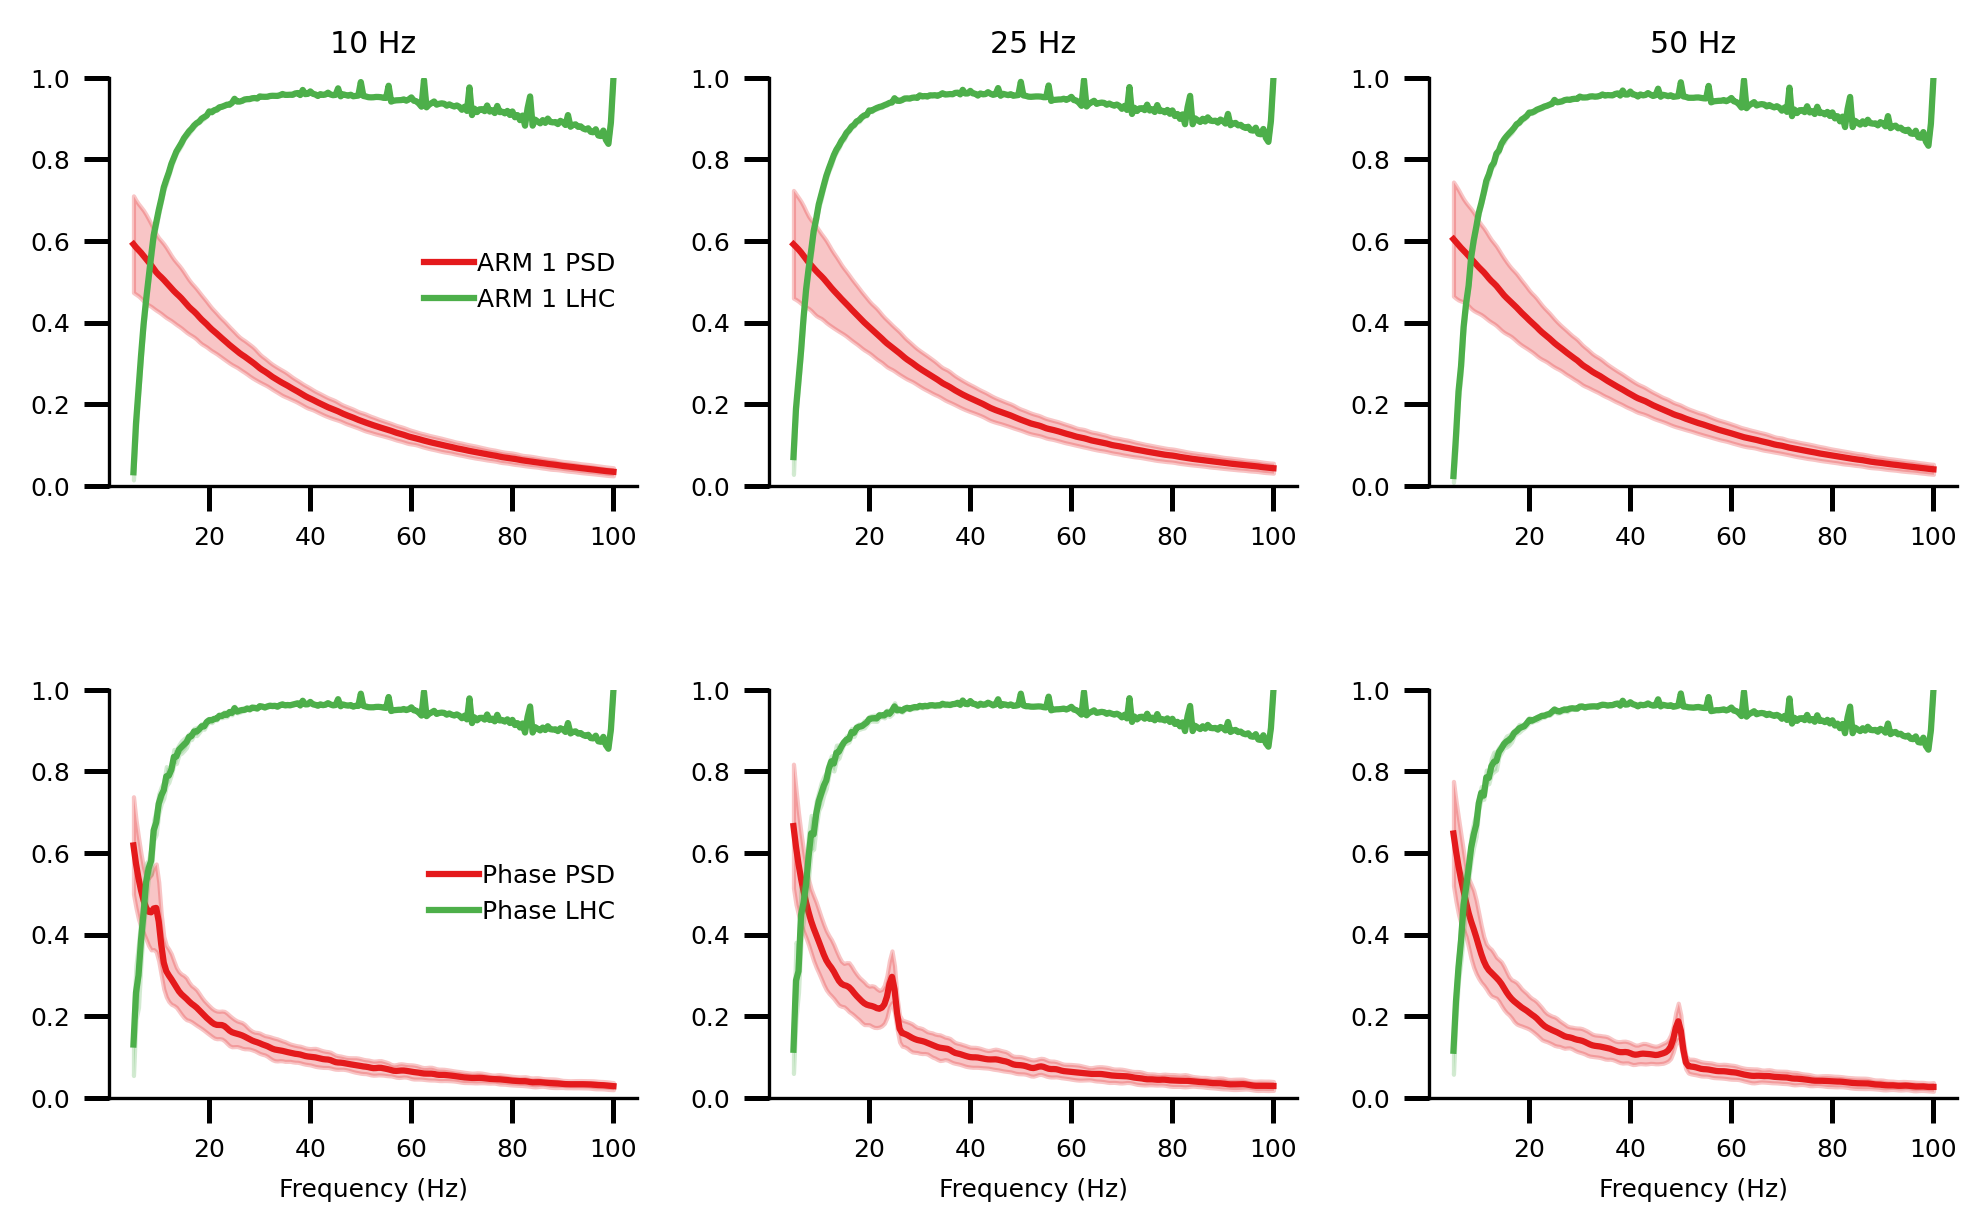

In [ ]:
# Plot PSDs and lagged Hilbert autocoherence of surrogate signals.

plt.rcParams.update({
    'font.size': 6,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

lch_color = np.array([77,175,74]) / 255
psd_color = np.array([228,26,28]) / 255

fig = plt.figure(
    constrained_layout=False,
    figsize=(7, 4),
    dpi=300,
)
gs = fig.add_gridspec(
    nrows=1,
    ncols=1,
    right=0.95,
    left=0.07,
    top=0.95,
    bottom=0.10,
)
gs0 = gs[0].subgridspec(2, 3, hspace=0.50, wspace=0.25)

for m, method in enumerate(surr_methods):

    for f, fr in enumerate(osc_f):

        # Load data.
        wdir = join(p_dir, "osc_{}/".format(int(fr)))
        
        freqs = np.load(join(wdir, "osc_freqs.npy"))
        surrogate_psds = np.load(join(wdir, "surr_{}_osc_psds.npy".format("arma" if method == "arma" else "phs")))
        lcs_hilbert = np.load(join(wdir, "sur_{}_osc_lcs_hilbert.npy".format("arma" if method == "arma" else "phs")))

        # Average data across shuffles (and lags) and apply scaling.
        # Min-max scaling in the [0, 1] interval makes the lagged autocoherence fluctuations more obvious.
        sap = np.nanmean(surrogate_psds, axis=1)
        sap = ( sap - np.nanmin(sap) ) / ( np.nanmax(sap) - np.nanmin(sap) ) # np.nanmax(sap) #
        sap_m = np.nanmean(sap, axis=0)
        sap_sd = np.nanstd(sap, axis=0)
        
        lch = np.nanmean(lcs_hilbert, axis=(1,3))
        lch = ( lch - np.nanmin(lch) ) / ( np.nanmax(lch) - np.nanmin(lch) ) # np.nanmax(lch) #
        lch_m = np.nanmean(lch, axis=0)
        lch_sd = np.nanstd(lch, axis=0)

        # Plot.
        ax0 = fig.add_subplot(gs0[m,f])

        ax0.plot(
            freqs,
            sap_m,
            label='ARM 1 PSD' if method == "arma" else 'Phase PSD',
            color=psd_color,
            zorder=0,
        )
        ax0.fill_between(
            freqs,
            sap_m - sap_sd,
            sap_m + sap_sd,
            color=psd_color,
            alpha=0.25,
            zorder=0,
        )

        ax0.plot(
            freqs,
            lch_m,
            label='ARM 1 LHC' if method == "arma" else 'Phase LHC',
            color=lch_color,
            zorder=0,
        )
        ax0.fill_between(
            freqs,
            lch_m - lch_sd,
            lch_m + lch_sd,
            color=lch_color,
            alpha=0.25,
            zorder=0,
        )

        if m == 0:
            ax0.set_title("{} Hz".format(fr))
        if m == 1:
            ax0.set_xlabel('Frequency (Hz)')
        ax0.set_ylim([0, 1])
        
        if f == 0:
            ax0.legend(loc="right")

plt.show()

In [6]:
# Compute lagged Hilbert autocoherence of simulated data.

# Generate and autocoherence per frequency.
for f_idx, f in enumerate(osc_f):

    print('Analyzing simulated {} Hz oscillatory signals.'.format(f))

    wdir = join(p_dir, "osc_{}/".format(int(f)))
    
    freqs = np.load(join(wdir, "osc_freqs.npy"))

    for method in surr_methods:
        signals = np.load(join(wdir, "osc_signals.npy"))
        surrogate_signals = np.load(join(wdir, "surr_{}_osc_signals.npy".format("arma" if method == "arma" else "phs")))

        lcs_hilbert = lagged_hilbert_autocoherence(
            signals,
            freqs,
            lags,
            srate,
            thresh_prctile=95,
            surr_data=surrogate_signals,
            n_jobs=-1,
        )

        np.save(join(wdir, "sim_{}_osc_lcs_hilbert".format("arma" if method == "arma" else "phs")), lcs_hilbert)

Analyzing simulated 10 Hz oscillatory signals.
Analyzing simulated 25 Hz oscillatory signals.
Analyzing simulated 50 Hz oscillatory signals.


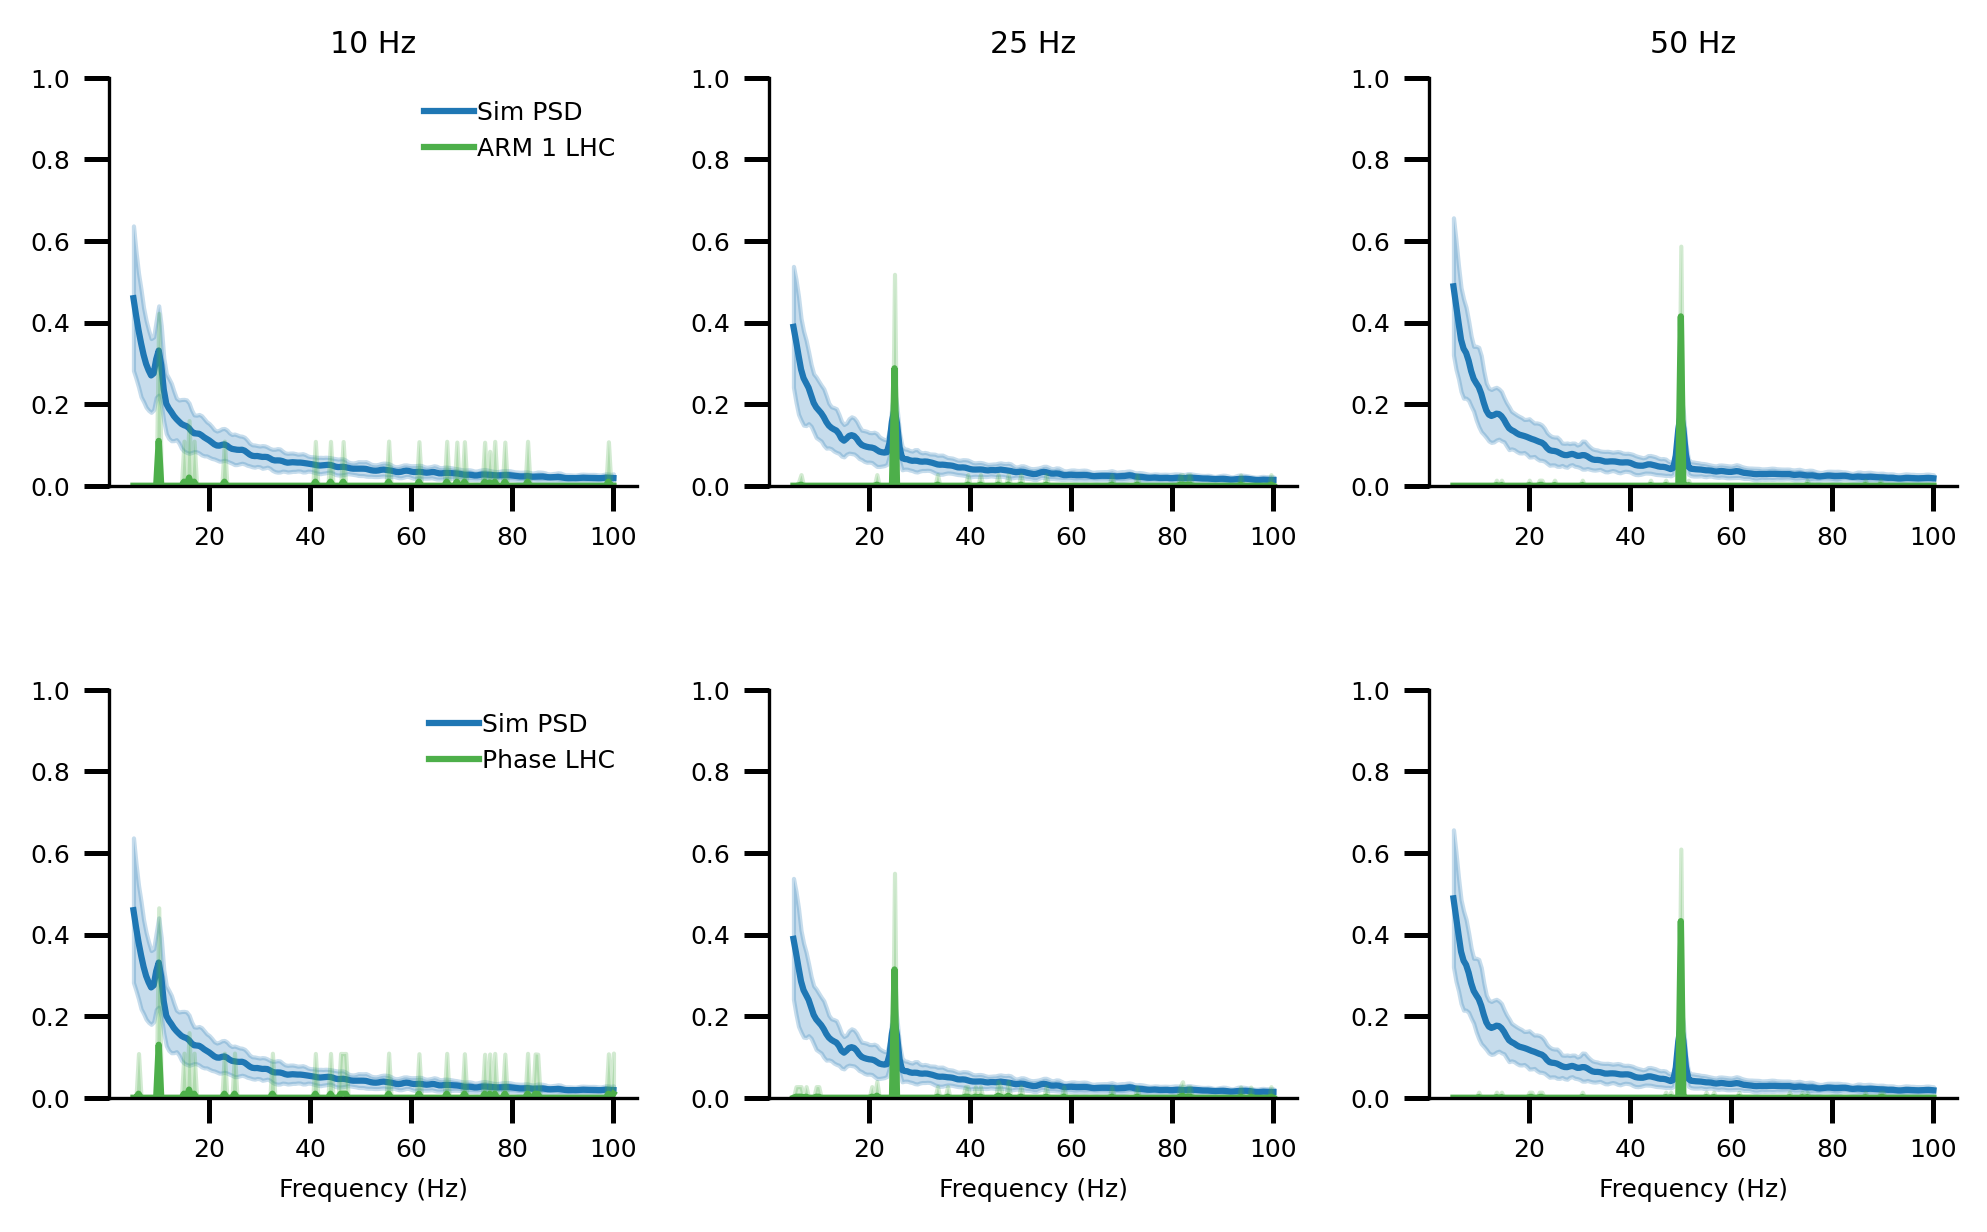

In [ ]:
# Plot PSDs of simulated signals and the lagged Hilbert autocoherence thresholded by the surrogate data.

plt.rcParams.update({
    'font.size': 6,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

lch_color = np.array([77,175,74]) / 255
sim_color = "tab:blue"

fig = plt.figure(
    constrained_layout=False,
    figsize=(7, 4),
    dpi=300,
)
gs = fig.add_gridspec(
    nrows=1,
    ncols=1,
    right=0.95,
    left=0.07,
    top=0.95,
    bottom=0.10,
)
gs0 = gs[0].subgridspec(2, 3, hspace=0.50, wspace=0.25)

for m, method in enumerate(surr_methods):

    for f, fr in enumerate(osc_f):

        # Load data.
        wdir = join(p_dir, "osc_{}/".format(int(fr)))
        
        freqs = np.load(join(wdir, "osc_freqs.npy"))
        psds = np.load(join(wdir, "osc_psds.npy"))
        lcs_hilbert = np.load(join(wdir, "sim_{}_osc_lcs_hilbert.npy".format("arma" if method == "arma" else "phs")))

        # Average data across shuffles (and lags) and apply scaling.
        psd = ( psds - np.nanmin(psds) ) / ( np.nanmax(psds) - np.nanmin(psds) ) # np.nanmax(psds) #
        psd_m = np.nanmean(psd, axis=0)
        psd_sd = np.nanstd(psd, axis=0)
        
        lch = np.nanmean(lcs_hilbert, axis=2)
        lch = ( lch - np.nanmin(lch) ) / ( np.nanmax(lch) - np.nanmin(lch) ) # np.nanmax(lch) #
        lch[np.isnan(lch)]=0
        lch_m = np.nanmean(lch, axis=0)
        lch_sd = np.nanstd(lch, axis=0)

        # Plot.
        ax0 = fig.add_subplot(gs0[m,f])
        
        ax0.plot(
            freqs,
            psd_m,
            label='Sim PSD' if method == "arma" else 'Sim PSD',
            color=sim_color,
            zorder=0,
        )
        ax0.fill_between(
            freqs,
            psd_m - psd_sd,
            psd_m + psd_sd,
            color=sim_color,
            alpha=0.25,
            zorder=0,
        )
        
        ax0.plot(
            freqs,
            lch_m,
            label='ARM 1 LHC' if method == "arma" else 'Phase LHC',
            color=lch_color,
            zorder=0,
        )
        ax0.fill_between(
            freqs,
            lch_m - lch_sd,
            lch_m + lch_sd,
            color=lch_color,
            alpha=0.25,
            zorder=1,
        )
        
        if m == 0:
            ax0.set_title("{} Hz".format(fr))
        if m == 1:
            ax0.set_xlabel('Frequency (Hz)')
        ax0.set_ylim([0, 1])
        
        if f == 0:
            ax0.legend(loc="upper right")

plt.show()